In [1]:
%%javascript
document.title='Jupyter Lab - Oil prices.ipynb'

<IPython.core.display.Javascript object>

## Modules import

In [1]:
import matplotlib.pylab as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm  
import pandas as pd
import numpy as np
import os
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Dataset preprocess

In [2]:
def make_dataset(dir_path=None, split_by_years=False):
    dir_path = './data' if dir_path is None else dir_path
    files = [file for file in glob(DATASET_PATH + '/*') if '.' not in file.split('/')[-1]]
    df = []
    periods = []
    for file in tqdm(files):
        df_ = pd.read_csv(file, header=None)
        df_.columns = [0,1,'price','volume']
        df_['date'] = pd.to_datetime(df_[0] + ' ' + df_[1])
        df_ = df_[['date','price','volume']].set_index('date')
#         df_['file_name'] = file.split('/')[-1]
        #record first and the last date of each file
        file_name = file.split('/')[-1]
        first_entry = df_.iloc[0:1].copy()
        first_entry['file'] = file_name
        last_entry = df_.iloc[-1:].copy()
        last_entry['file'] = file_name
        periods += [first_entry, last_entry]
        df.append(df_)
    df = pd.concat(df).sort_index()
    df.to_csv('oil_dataset.csv')
    
    periods = pd.concat(periods)
    periods.to_csv('periods.csv')
    
    if split_by_years:
        for year in tqdm(df.groupby(pd.Grouper(freq='Y')).count().index.year):
            df_by_year = df.loc[df.index.year == year]
            df_by_year.to_csv('oil_dataset_' + str(year) + '.csv')

In [3]:
def read_dataset(file_path, verbose=True):
    if verbose:
        print('Loading dataset from:' , file_path)
    df = pd.read_csv(file_path, engine='c').set_index('date') #, index_col=0)
    df.index = pd.to_datetime(df.index).to_period('S')
    return df

In [ ]:
# %%time
# if os.path.exists('oil_dataset.csv'):
#     read_dataset('oil_dataset.csv')
# else:
#     make_dataset()

In [5]:
df = []
for year in tqdm(range(2010,2021)):
    df.append(read_dataset(f'oil_dataset_{year}.csv', verbose=False))
df = pd.concat(df)
df

,price,volume
date,,
2010-01-03 18:00:00,79.63,3
2010-01-03 18:00:00,79.63,4
2010-01-03 18:00:00,79.63,3
2010-01-03 18:00:00,79.63,2
2010-01-03 18:00:00,79.63,2
...,...,...
2020-05-19 14:00:26,31.73,2
2020-05-19 14:00:26,31.73,1
2020-05-19 14:00:26,31.73,1


## Resample

In [138]:
df.shape[0]

410999999

In [151]:
def resample(df, freq_dict, delta_threshold = 0.005, heatmap=True, bins=25, title=None, fig_size=(8,8)):
    
    if isinstance(freq_dict, str):
        freq_string = freq_dict
    else:
        freq_map = {'months': 'M', 'days': 'D', 'hours' : 'H', 'minutes' : 'T', "seconds" : 'S'}
        freq_string = ''

        for k in freq_map:
            if k in freq_dict and freq_dict[k]:
                freq_string += str(freq_dict[k]) + freq_map[k]
            
    resampled = df.resample(freq_string).agg({"price": ['first', 'last', 'mean']})
    resampled.columns = resampled.columns.droplevel(0)
    resampled['delta'] = resampled['last']/resampled['first'] - 1
    resampled.dropna(inplace=True)
    resampled['delta_next_time'] = resampled['delta'].shift(-1).values
    resampled = resampled.iloc[:-1]
    resampled = resampled.loc[np.abs(resampled['delta']) > 0.95*delta_threshold]
    #check if minimum price change equals three ticks of this contract
    resampled = resampled.loc[np.abs(resampled['delta']) * resampled['mean'] > 0.03]

    if heatmap:
        bins_suffix = ''
        if bins and bins < resampled.shape[0]:
            #make bins to downsample the data
            bins_suffix = '_bins'
            for column in ['delta', 'delta_next_time']:
                bins_space = np.linspace(resampled[column].min(), resampled[column].max(), bins)
                digitized = np.digitize(resampled[column], bins_space, right=True)
                resampled[column + bins_suffix] = (np.take(bins_space, digitized) + np.take(bins_space, digitized - 1))/2
        
        #crosstab to count every pair 
        cross = pd.crosstab(resampled['delta' + bins_suffix], resampled['delta_next_time' + bins_suffix])
        cross.index, cross.columns = np.round(cross.index,4), np.round(cross.columns,4)
        cross.index.name, cross.columns.name = 'delta', 'delta_next_time'
        cross = cross.iloc[::-1]

        fig, ax = plt.subplots(figsize=fig_size)
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])   
        title = title if title else f'''Deltas and next_deltas pairs for {resampled.index[0].year if df.shape[0] != 410999999 else 
                                        'all years'} with {delta_threshold} delta threshold \n and {freq_dict} time'''
        ax.set_title(title, weight='bold', size=12, linespacing=1.25)
#         ax.axvline(1, 0, 2, linewidth=1, c='r')

        
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)
        
        heatmap = sns.heatmap(cross, ax=ax, cbar=True, cbar_kws={"shrink": .55}, square=True,xticklabels=True, yticklabels=True)
        plt.yticks(rotation=0) 
        plt.xticks(rotation=45)
        ax.set_aspect('equal','box')
        plt.axis('scaled')
        plt.show()
    
    return resampled

## Heatmaps all years

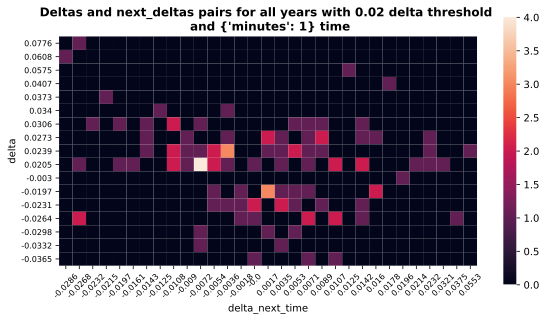

,first,last,mean,delta,delta_next_time,delta_bins,delta_next_time_bins
date,,,,,,,
2011-05-06 08:30,98.00,100.00,99.241602,0.020408,-0.007407,0.020539,-0.007181
2011-08-05 08:30,85.56,88.19,87.296182,0.030739,-0.007938,0.030607,-0.007181
2015-10-28 10:00,43.92,44.93,44.466778,0.022996,-0.010908,0.023895,-0.010751
2016-01-13 10:30,31.34,30.62,30.787104,-0.022974,-0.004247,-0.023093,-0.003610
2016-02-03 10:46,30.54,31.14,30.849341,0.019646,-0.005461,0.020539,-0.005395
...,...,...,...,...,...,...,...
2020-04-30 20:10,19.84,20.31,20.050793,0.023690,-0.004926,0.023895,-0.005395
2020-05-01 14:28,20.12,19.72,19.843612,-0.019881,0.002535,-0.019737,0.001746
2020-05-06 10:30,23.44,24.06,23.977520,0.026451,0.001663,0.027251,0.001746


In [152]:
out = resample(df, dict(minutes=1), delta_threshold=0.02, bins=50)
out

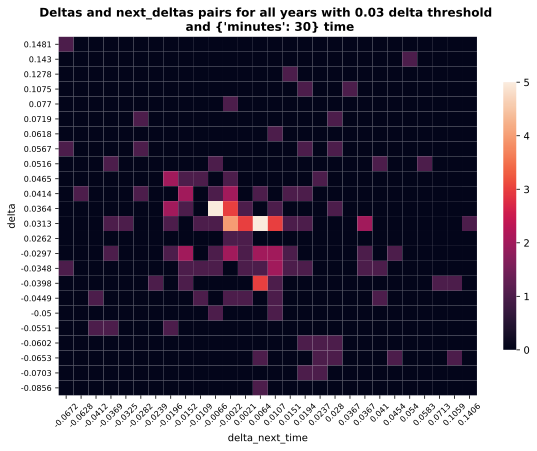

,first,last,mean,delta,delta_next_time,delta_bins,delta_next_time_bins
date,,,,,,,
2011-05-06 03:30,98.95,96.08,96.764531,-0.029005,-0.000312,-0.029689,-0.002245
2014-11-27 11:00,70.39,68.07,69.171704,-0.032959,0.018355,-0.034769,0.019394
2014-12-17 11:30,56.43,58.32,57.748940,0.033493,-0.002572,0.031276,-0.002245
2015-01-14 14:00,46.36,48.56,47.531756,0.047455,-0.011120,0.046518,-0.010901
2015-01-30 14:00,46.59,48.17,47.485148,0.033913,-0.017646,0.036357,-0.019557
...,...,...,...,...,...,...,...
2020-05-06 08:30,23.52,22.79,22.980006,-0.031037,0.043440,-0.029689,0.045360
2020-05-06 09:00,22.79,23.78,23.340822,0.043440,-0.014712,0.041437,-0.015229
2020-05-07 05:30,24.69,25.75,25.366775,0.042932,0.013592,0.041437,0.015066


In [153]:
out = resample(df, dict(minutes=30), delta_threshold=0.03, bins=50)
out

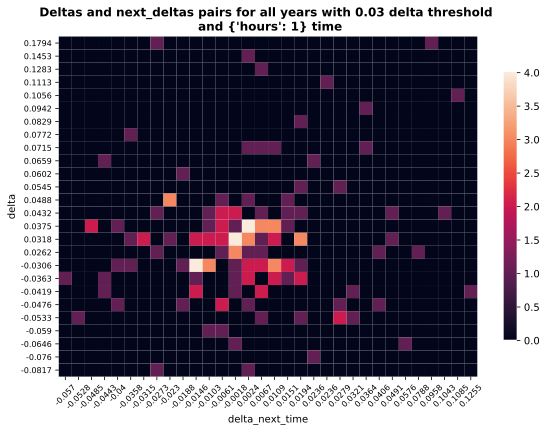

,first,last,mean,delta,delta_next_time,delta_bins,delta_next_time_bins
date,,,,,,,
2010-02-05 11:00,72.92,70.44,70.949264,-0.034010,0.003974,-0.036265,0.002417
2011-02-24 02:00,99.29,102.16,100.908511,0.028905,-0.002938,0.026151,-0.001827
2011-05-06 03:00,99.30,96.08,97.150655,-0.032427,0.011349,-0.030591,0.010905
2011-08-08 14:00,83.42,80.50,81.883043,-0.035004,0.002857,-0.036265,0.002417
2011-08-08 20:00,80.34,78.04,79.118648,-0.028628,-0.019990,-0.030591,-0.018802
...,...,...,...,...,...,...,...
2020-05-06 09:00,22.79,23.44,23.459919,0.028521,0.005970,0.026151,0.006661
2020-05-07 05:00,24.09,25.75,25.075662,0.068908,0.012039,0.071545,0.010905
2020-05-07 13:00,24.98,24.23,24.244685,-0.030024,-0.036319,-0.030591,-0.035777


In [154]:
out = resample(df, dict(hours=1), delta_threshold=0.03, bins=50)
out

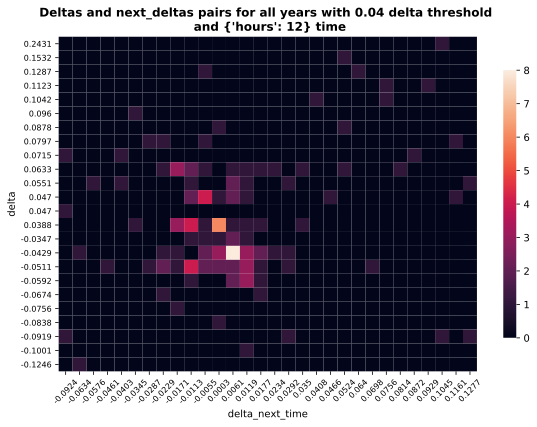

,first,last,mean,delta,delta_next_time,delta_bins,delta_next_time_bins
date,,,,,,,
2010-02-04 06:00,76.31,72.97,74.047735,-0.043769,-0.001233,-0.042904,0.000275
2010-06-04 06:00,75.01,70.91,72.585746,-0.054659,0.012626,-0.051074,0.011859
2010-06-25 06:00,76.09,79.19,77.905223,0.040741,-0.009114,0.038802,-0.011308
2010-07-07 06:00,71.91,74.91,73.488897,0.041719,-0.000134,0.038802,0.000275
2010-10-19 06:00,83.45,79.86,81.534706,-0.043020,0.014761,-0.042904,0.017651
...,...,...,...,...,...,...,...
2020-05-06 18:00,24.09,25.75,24.278784,0.068908,-0.091650,0.071484,-0.092393
2020-05-07 06:00,25.75,23.39,25.259856,-0.091650,0.027005,-0.091927,0.029234
2020-05-13 18:00,25.97,26.98,26.197705,0.038891,0.037064,0.038802,0.035026


In [155]:
out = resample(df, dict(hours=12), delta_threshold=0.04, bins=50)
out

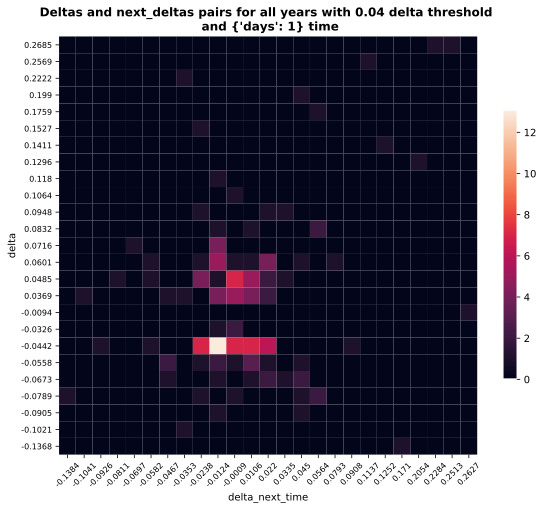

,first,last,mean,delta,delta_next_time,delta_bins,delta_next_time_bins
date,,,,,,,
2010-02-04,76.99,73.36,74.146956,-0.047149,-0.020038,-0.044175,-0.023818
2010-02-16,74.38,77.41,76.438391,0.040737,-0.005945,0.036897,-0.000894
2010-05-04,85.82,82.39,83.669070,-0.039967,-0.027552,-0.044175,-0.023818
2010-05-17,70.26,74.03,70.511150,0.053658,-0.025125,0.048478,-0.023818
2010-05-20,72.96,70.18,70.366173,-0.038103,0.003990,-0.032593,-0.000894
...,...,...,...,...,...,...,...
2020-05-04,19.06,21.81,19.797151,0.144281,0.120128,0.141132,0.125191
2020-05-05,21.81,24.43,23.687622,0.120128,-0.018011,0.117968,-0.012356
2020-05-07,23.98,25.35,25.111270,0.057131,0.027624,0.060060,0.022031


In [156]:
out = resample(df, dict(days=1), delta_threshold=0.04, bins=50)
out

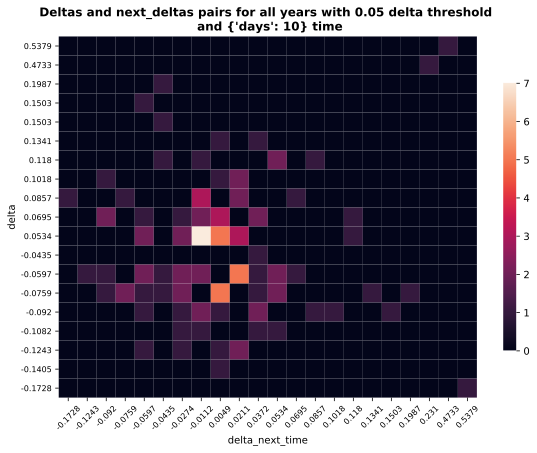

,first,last,mean,delta,delta_next_time,delta_bins,delta_next_time_bins
date,,,,,,,
2010-01-13,80.01,74.09,77.851127,-0.073991,0.006466,-0.075853,0.004909
2010-02-12,74.87,80.32,76.794072,0.072793,0.000993,0.069518,0.004909
2010-03-24,81.28,85.25,81.940749,0.048844,-0.014301,0.053366,-0.011244
2010-05-03,86.07,75.40,78.819768,-0.123969,-0.065526,-0.124310,-0.059701
2010-05-13,75.39,70.45,71.891339,-0.065526,0.020532,-0.059701,0.021061
...,...,...,...,...,...,...,...
2020-03-11,35.26,33.25,33.499504,-0.057005,-0.026075,-0.059701,-0.027396
2020-03-31,21.29,23.20,24.720355,0.089713,-0.174390,0.085670,-0.172767
2020-04-10,24.60,20.31,21.728826,-0.174390,0.546012,-0.172767,0.537936


In [157]:
out = resample(df, dict(days=10), delta_threshold=0.05, bins=50)
out

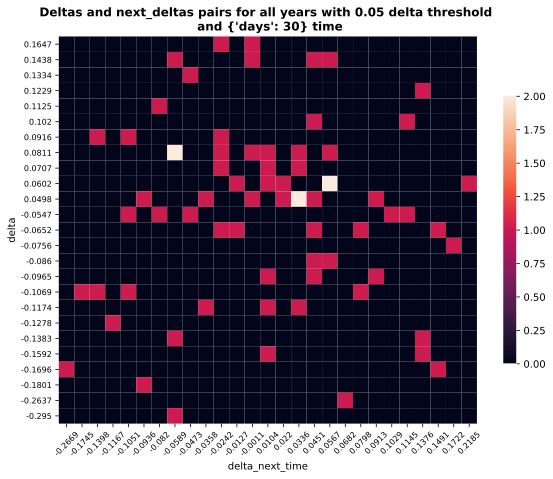

,first,last,mean,delta,delta_next_time,delta_bins,delta_next_time_bins
date,,,,,,,
2010-01-03,79.63,74.72,78.046210,-0.061660,0.079095,-0.065153,0.079782
2010-02-02,74.72,80.63,76.405922,0.079095,0.057299,0.081122,0.056669
2010-03-04,80.63,85.25,81.550374,0.057299,0.008909,0.060226,0.010443
2010-05-03,86.07,72.07,74.610734,-0.162658,0.015961,-0.159187,0.010443
2010-07-02,73.21,78.99,76.500441,0.078951,-0.062698,0.081122,-0.058896
...,...,...,...,...,...,...,...
2019-06-15,52.50,60.07,57.534795,0.144190,-0.061095,0.143811,-0.058896
2019-07-15,60.07,56.40,55.817744,-0.061095,-0.025705,-0.065153,-0.024227
2020-02-10,50.19,35.26,45.274247,-0.297470,-0.342031,-0.295014,-0.058896


In [158]:
out = resample(df, dict(days=30), delta_threshold=0.05, bins=50)
out

## Heatmaps by year

Loading dataset from:  oil_dataset_2010.csv


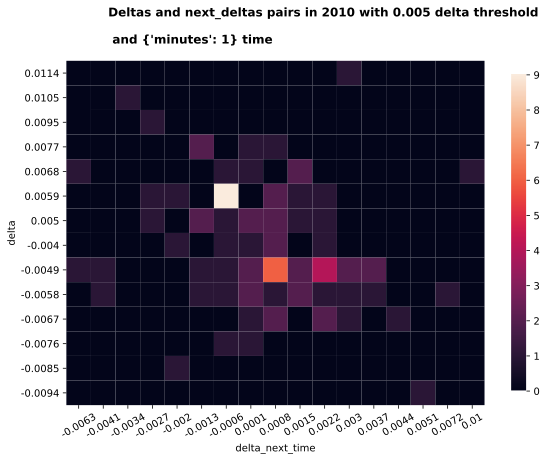

,first,last,mean,delta,delta_next_time,delta_bins,delta_next_time_bins
date,,,,,,,
2010-01-06 10:30,82.16,81.49,81.616647,-0.008155,-0.000736,-0.007622,-0.000590
2010-01-06 11:21,81.95,82.67,82.267513,0.008786,-0.003145,0.009547,-0.002718
2010-01-12 16:30,80.55,80.16,80.300313,-0.004842,-0.001123,-0.004008,-0.000590
2010-01-13 10:30,79.06,78.47,78.703080,-0.007463,0.002039,-0.006719,0.002247
2010-01-21 11:09,77.12,76.49,76.928212,-0.008169,0.000000,-0.007622,0.000119
...,...,...,...,...,...,...,...
2010-11-03 14:16,84.33,84.88,84.703099,0.006522,0.000000,0.006836,0.000119
2010-11-09 16:30,85.95,86.36,86.153450,0.004770,-0.000347,0.005029,0.000119
2010-11-24 10:59,82.43,82.89,82.695039,0.005580,0.000603,0.005933,0.000828


Loading dataset from:  oil_dataset_2011.csv


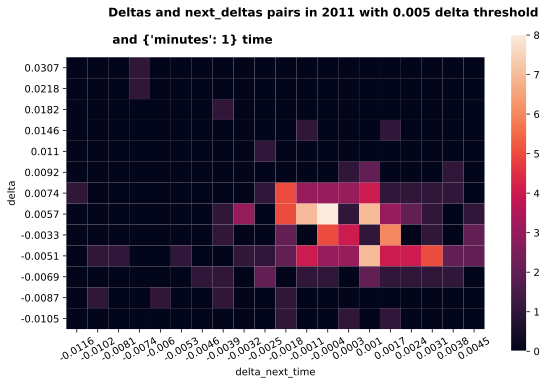

,first,last,mean,delta,delta_next_time,delta_bins,delta_next_time_bins
date,,,,,,,
2011-01-10 13:27,88.84,89.28,89.092504,0.004953,0.000336,0.005654,0.001026
2011-02-09 13:07,86.79,87.22,87.037651,0.004954,-0.000917,0.005654,-0.000373
2011-02-11 11:06,86.10,85.68,85.823431,-0.004878,0.002567,-0.003305,0.003124
2011-02-22 10:37,94.61,94.12,94.324668,-0.005179,0.000744,-0.005097,0.001026
2011-02-24 02:55,101.46,103.30,102.600835,0.018135,-0.004462,0.018196,-0.003871
...,...,...,...,...,...,...,...
2011-11-07 06:59,94.54,94.09,94.282138,-0.004760,0.004039,-0.003305,0.004523
2011-11-30 08:00,99.68,100.55,100.293450,0.008728,0.003282,0.009237,0.003824
2011-12-13 09:45,99.35,100.63,100.275484,0.012884,-0.001391,0.014613,-0.001073


Loading dataset from:  oil_dataset_2012.csv


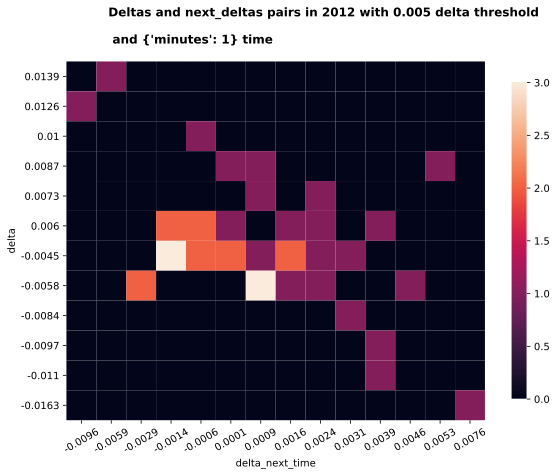

,first,last,mean,delta,delta_next_time,delta_bins,delta_next_time_bins
date,,,,,,,
2012-01-12 14:15,99.79,99.17,99.489270,-0.006213,0.001008,-0.005771,0.001605
2012-01-12 14:28,99.50,98.97,99.181015,-0.005327,0.000909,-0.004459,0.001605
2012-01-20 09:02,99.74,99.26,99.431012,-0.004813,0.000604,-0.004459,0.000856
2012-01-25 13:15,99.88,100.37,100.153664,0.004906,-0.001893,0.006036,-0.001390
2012-02-13 09:01,100.01,100.52,100.278910,0.005099,-0.001094,0.006036,-0.000641
2012-03-15 11:38,104.50,103.89,104.098790,-0.005837,0.003946,-0.005771,0.004599
2012-03-15 12:02,104.20,105.16,104.744407,0.009213,-0.001236,0.009972,-0.000641
2012-03-23 09:55,106.42,107.90,107.209053,0.013907,-0.006210,0.013907,-0.005881
2012-03-23 09:56,107.89,107.22,107.630711,-0.006210,-0.003544,-0.005771,-0.002887


Loading dataset from:  oil_dataset_2013.csv


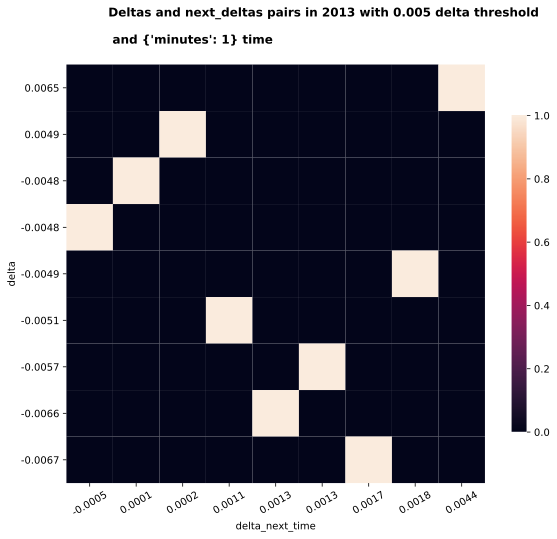

,first,last,mean,delta,delta_next_time
date,,,,,
2013-02-15 09:15,96.22,95.76,95.941284,-0.004781,-0.000522
2013-02-20 11:01,95.81,95.18,95.374374,-0.006576,0.001261
2013-04-05 08:30,92.65,92.03,92.142726,-0.006692,0.001739
2013-05-03 08:30,94.29,94.90,94.702142,0.006469,0.004426
2013-05-07 10:13,95.61,95.14,95.353532,-0.004916,0.001787
2013-05-14 14:00,94.73,94.28,94.392152,-0.004750,0.000106
2013-08-21 10:31,104.93,104.39,104.644671,-0.005146,0.001054
2013-10-02 10:32,102.40,102.90,102.726210,0.004883,0.000194
2013-10-09 10:30,102.01,101.43,101.603697,-0.005686,0.001282


Loading dataset from:  oil_dataset_2014.csv


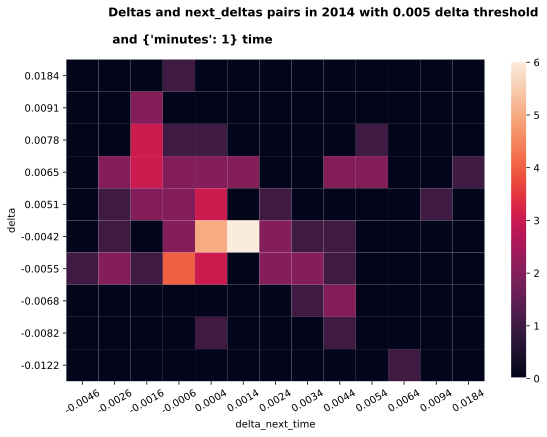

,first,last,mean,delta,delta_next_time,delta_bins,delta_next_time_bins
date,,,,,,,
2014-03-02 18:00,103.00,103.73,103.403481,0.007087,-0.001928,0.007794,-0.001630
2014-04-08 12:40,101.78,102.31,102.090701,0.005207,0.000489,0.006464,0.001380
2014-09-30 11:34,92.76,92.20,92.359258,-0.006037,-0.001193,-0.005507,-0.000627
2014-10-07 23:38,88.31,87.84,87.995224,-0.005322,0.000911,-0.004177,0.001380
2014-10-14 14:30,81.81,81.33,81.689760,-0.005867,0.003686,-0.005507,0.004390
...,...,...,...,...,...,...,...
2014-12-26 04:01,56.20,55.91,56.019023,-0.005160,0.000536,-0.004177,0.001380
2014-12-28 19:01,55.34,55.62,55.494469,0.005060,-0.000899,0.005134,-0.000627
2014-12-29 12:16,54.06,53.68,53.857968,-0.007029,0.002422,-0.006837,0.003386


In [208]:
for year in [2010, 2011, 2012, 2013, 2014]:
    df = read_dataset(f'oil_dataset_{year}.csv')
    out = resample(df,dict(minutes=1), delta_threshold=0.005)
    display(out)